The data to run this notebook is here (ask Eric if you still don't have access to the shared drive): https://drive.google.com/drive/u/0/folders/1uF3sh9ZHD2jN20YtBZN-2dxolq1FElke

Download the folder, extract it, and rename to `arc_test`, then put it under `2024_test_data`

In [1]:
%load_ext autoreload
%autoreload 2
import os
from uavf_2024.imaging import Camera, Localizer
from uavf_2024.imaging.imaging_types import FullBBoxPrediction
from scipy.spatial.transform import Rotation as R
from itertools import product
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

files_dir = f"2024_test_data/arc_test"
visualizations_dir = f"visualizations/localizations"
os.makedirs(visualizations_dir, exist_ok=True)

localizer = Localizer.from_focal_length(
    Camera.focalLengthFromZoomLevel(1), 
    (1920, 1080),
    (np.array([1,0,0]), np.array([0,-1, 0])),
    2    
)

positions = []
drone_orientations = []
logged_cam_orientations = []
start_angles = []
end_angles = []
imgs = []

for i in range(len(os.listdir(files_dir))):
    img_file = f"{files_dir}/img_{i}/bounding_boxes.png"
    pose_file = f"{files_dir}/img_{i}/cam_pose.txt"
    img = cv.imread(img_file)
    imgs.append(img)
    with open(pose_file, 'r') as f:
        lines = f.readlines()

        position = tuple(map(float, lines[0].split(',')))
        drone_orientation = tuple(map(float, lines[2].split(',')))
        drone_orientation = R.from_quat(drone_orientation)
        cam_orientation = tuple(map(float, lines[1].split(',')))
        cam_orientation = R.from_quat(cam_orientation)
        start_angle = np.array(tuple(map(float, lines[3][1:-2].split(', '))))
        end_angle = np.array(tuple(map(float, lines[4][1:-2].split(', '))))

        positions.append(np.array(position))
        drone_orientations.append(drone_orientation)
        logged_cam_orientations.append(cam_orientation)
        start_angles.append(np.array(start_angle))
        end_angles.append(np.array(end_angle))


In [2]:
computed_cam_orientations = []
for start_angle, end_angle, drone_orientation in zip(start_angles, end_angles, drone_orientations):
    avg_angle = (start_angle + end_angle) / 2
    orientation = Camera.orientation_in_world_frame(drone_orientation, avg_angle)
    computed_cam_orientations.append(orientation)

recorded_coords = np.array([0.2,-6.7,0]) # actuallly 0.2,-6.7,-3.8 but I made the z zero

frame_indices = [
    30, 46, 47, 50, 53, 57, 64, 86, 88
]

# TODO: visualize pixel coordinates

pixel_coords = [
    (330, 625),
    (926, 197),
    (1425, 885),
    (1798, 1016),
    (1136, 622),
    (1264, 1044),
    (924, 734),
    (765, 87),
    (1786, 184)
]

# frame_indices = frame_indices[5:6]
# pixel_coords = pixel_coords[5:6]

all_coords_3d = []

for i, xy in zip(frame_indices, pixel_coords):
    x, y = xy
    coords_3d = localizer.prediction_to_coords(
        FullBBoxPrediction(x,y,0,0, None), 
        (positions[i], computed_cam_orientations[i]),
        
    )
    all_coords_3d.append(coords_3d)
    print(coords_3d.position)


[   -0.84721     -7.5314           0]
[   0.030534     -8.5159           0]
[     3.6524     -9.0386           0]
[     1.2204     -9.5944           0]
[     1.6688     -3.6583           0]
[   -0.83028     -10.055           0]
[    0.58619     -7.4806           0]
[   -0.51352       -7.92           0]
[     2.3099     -7.2131           0]


XY: 330, 625 -> (330.0000000000001, 625.0)


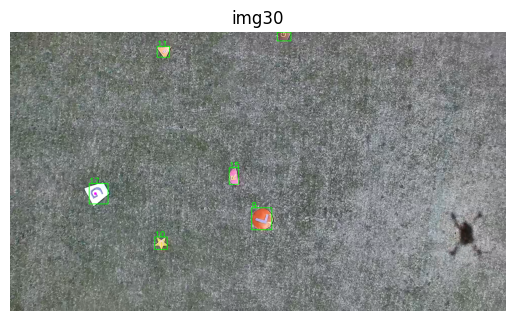

XY: 926, 197 -> (926.0, 197.0000000000001)


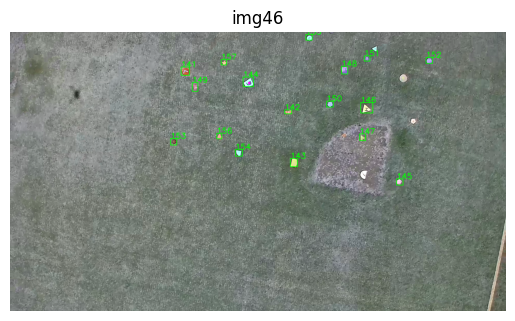

XY: 1425, 885 -> (1425.0000000000002, 884.9999999999999)


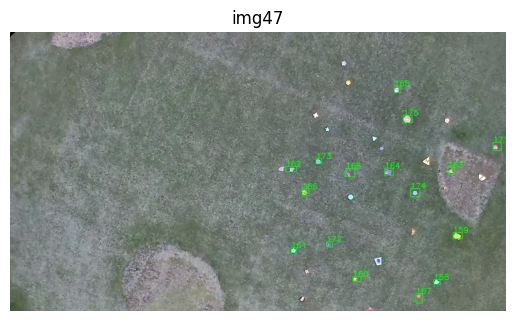

XY: 1798, 1016 -> (1798.0000000000002, 1016.0000000000001)


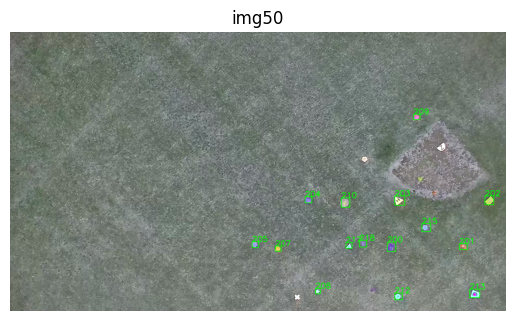

XY: 1136, 622 -> (1136.0, 621.9999999999999)


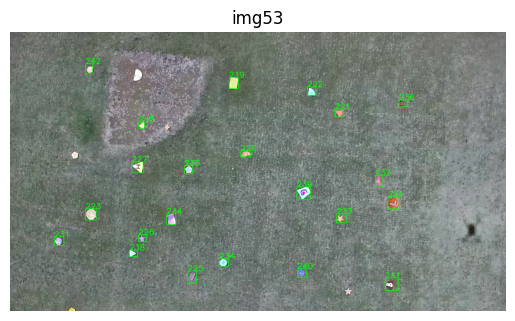

XY: 1264, 1044 -> (1264.0, 1044.0)


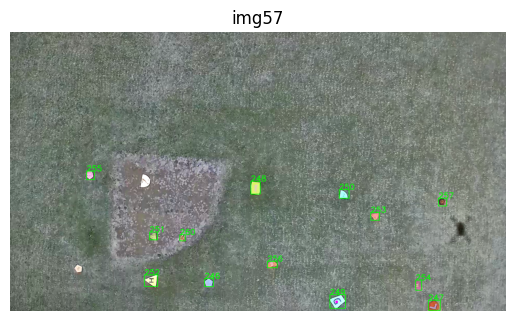

XY: 924, 734 -> (924.0, 733.9999999999999)


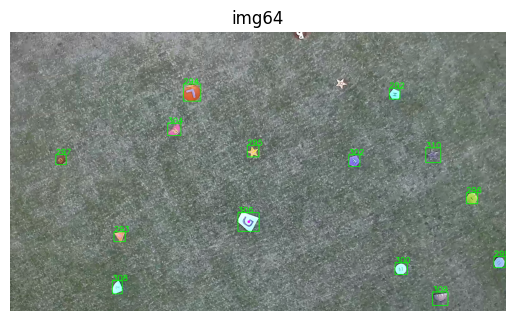

XY: 765, 87 -> (765.0, 86.99999999999994)


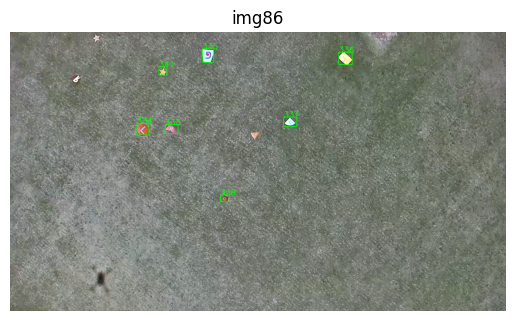

XY: 1786, 184 -> (1786.0, 184.00000000000023)


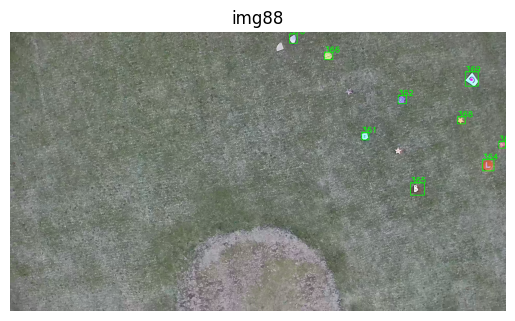

In [5]:
for i, xy in zip(frame_indices, pixel_coords):
    target_x, target_y = xy
    coords_3d = localizer.prediction_to_coords(
        FullBBoxPrediction(target_x,target_y,0,0, None), 
        (positions[i], computed_cam_orientations[i]),
    )
    reprojected = localizer.coords_to_2d(coords_3d.position, (positions[i], computed_cam_orientations[i]))
    print(f"XY: {target_x}, {target_y} -> {reprojected}")

    drone_orientation = drone_orientations[i]
    angles = start_angles[i]
    for x,y in product(np.linspace(-20, 20, 41), np.linspace(-20, 20, 41)):
        coords_2d = localizer.coords_to_2d(np.array([x,y,0]), (positions[i], computed_cam_orientations[i]))
        coords_2d_int = tuple(map(int, coords_2d))
        if 0<=coords_2d[0]<1920 and 0<=coords_2d[1]<1080:
            cv.putText(img, f"{int(x)},{int(y)}", coords_2d_int, cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            cv.circle(img, coords_2d_int, 5, (255,255,0), -1)
    img = imgs[i].copy()
    cv.circle(img, (target_x,target_y), 5, (255,0,255), -1)
    plt.figure()
    plt.title(f"img{i}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

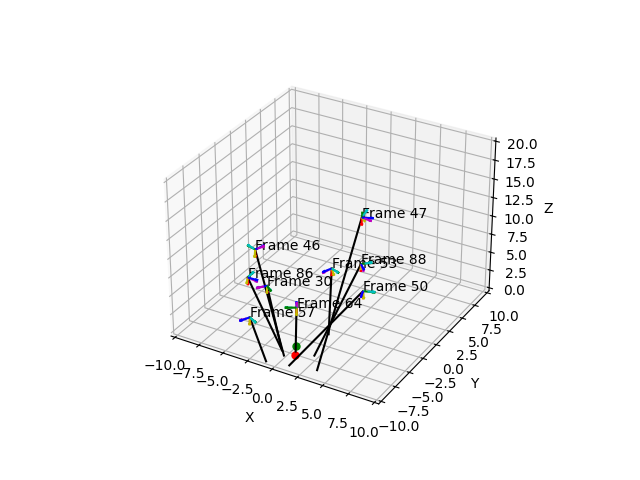

In [4]:
%matplotlib widget 
# initialize 3d plot and draw drone pose as quivers

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 20)

ax.plot([recorded_coords[0]], [recorded_coords[1]], [recorded_coords[2]], marker='o', markersize=5, color='g')
# plot average 3d estimate
avg = np.mean([coords_3d.position for coords_3d in all_coords_3d], axis=0)
ax.plot([avg[0]], [avg[1]], [avg[2]], marker='o', markersize=5, color='r')
for i in frame_indices:
    # plt.figure()
    # plt.title(f"Frame {i}")
    # plt.imshow(imgs[i])
    # plt.show()
    orientation: R = computed_cam_orientations[i]
    drone_orientation: R = logged_cam_orientations[i]
    
    position = positions[i]
    x_axis = orientation.apply([1,0,0])
    y_axis = orientation.apply([0,1,0])
    z_axis = orientation.apply([0,0,1])
    ax.quiver(*position, x_axis[0], x_axis[1], x_axis[2], color='r')
    ax.quiver(*position, y_axis[0], y_axis[1], y_axis[2], color='g')
    ax.quiver(*position, z_axis[0], z_axis[1], z_axis[2], color='b')

    ax.text(*position, f"Frame {i}", color='black')

    ax.quiver(*position, drone_orientation.apply([1,0,0])[0], drone_orientation.apply([1,0,0])[1], drone_orientation.apply([1,0,0])[2], color='y', linestyle='dashed')
    ax.quiver(*position, drone_orientation.apply([0,1,0])[0], drone_orientation.apply([0,1,0])[1], drone_orientation.apply([0,1,0])[2], color='c', linestyle='dashed')
    ax.quiver(*position, drone_orientation.apply([0,0,1])[0], drone_orientation.apply([0,0,1])[1], drone_orientation.apply([0,0,1])[2], color='m', linestyle='dashed')

    coords_3d = all_coords_3d[frame_indices.index(i)]

    ax.plot([position[0], coords_3d.position[0]], [position[1], coords_3d.position[1]], [position[2], coords_3d.position[2]], color='k')
plt.show()

In [5]:

for i, (position, cam_orientation, img) in enumerate(zip(positions, logged_cam_orientations, imgs)):
    for x,y in product(np.linspace(-10, 10, 21), np.linspace(-10, 10, 21)):
        coords_2d = localizer.coords_to_2d(np.array([x,y,0]), (position, cam_orientation))
        coords_2d_int = tuple(map(int, coords_2d))
        if 0<=coords_2d[0]<1920 and 0<=coords_2d[1]<1080:
            cv.putText(img, f"{int(x)},{int(y)}", coords_2d_int, cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            cv.circle(img, coords_2d_int, 5, (255,255,0), -1)
    cv.imwrite(f"{visualizations_dir}/img_{i}_localization.png", img) 